# Tennis Action Evaluator

## Introduction

### Problem

### Model Definition

#### State

#### Action

#### Rewards

### Data Processing

#### Raw Data

#### Extracted data

### Evaluation

We evaluate the model based on how well it estimates the actual probability that the agent at state $s$ performing action $a$ will win the rally.

We do this by passing a list of $(s,a)$ pairs to the estimator model to get the $Q(s,a)$ indicating the probability of the agent winning. Each $(s,a)$ pair has already been marked as belonging to the winner or the loser of the rally.

We deem a prediction correct in the following cases:
1. The $(s,a)$ pair belongs to the winner and gives a $Q(s,a) \ge 0.5$ 
2. The $(s,a)$ pair belongs to the loser and gives a $Q(s,a) \lt 0.5$

The final score of the model is calculated using $\frac{\text{correct predictions}}{\text{total predictions}}$.

## Approximated MC Learning

First, we tried a simple approximated MC learning to approximate the $Q(s,a)$ function as a baseline. This is a simple linear regression problem. We used `sklearn.linear_model.LinearRegression` to create an estimator model.

Since the reward of a tennis rally is only non-zero at the end of a rally, MC learning's behavior of looking at the accumulated rewards for an entire trial might be beneficial for estimating the Q-values of tennis actions.

### Training

Being that it is merely solving a system of linear equations, training of the estimator model is very quick for approximated MC learning.

In [1]:
import mc_learning as mc

mc_model = mc.train(save=False)
print(mc_model.coef_)

[[ 0.00046365  0.00620755  0.00934649 -0.02493163  0.0050135  -0.02148365
  -0.00191497 -0.00411411 -0.00643848  0.0220249  -0.00568214  0.02426598
   0.00129729 -0.00062967 -0.02203004  0.00634108 -0.00288176]]


### Evaluation

However, accuracy is low for this method, only correctly predicting the outcome of the $Q(s,a)$ correctly 53% of the time. The $Q(s,a)$ cannot be directly represented by a linear function of the features we have defined.

In [2]:
from data import test_dataset
import evaluation as eval

def mc_predict(sa_pair):
    single_sample_reshape = sa_pair.reshape(1,-1)
    pred = mc_model.predict(single_sample_reshape)
    return pred

score = eval.score_model(test_dataset, mc_predict)

print(f"Linear MC Learning Accuracy: {score}")

Linear MC Learning Accuracy: (0.5361596009975063, 0.24950967844844793)


## Deep Reinforcement Learning

### MC

#### Training

In [3]:
import d_sarsa

nn_mc_model, nn_mc_report = d_sarsa.train(save=False, use_mc=True)

EPOCH: 1.000  train_ave_loss: 0.252  train_ave_acc: 0.551  (3.88s - 772.36s remaining) ave_loss: 0.2517772841532209 ave_acc: 0.5508476191867674
EPOCH: 2.000  train_ave_loss: 0.243  train_ave_acc: 0.587  (6.70s - 663.40s remaining) ave_loss: 0.24329903868199093 ave_acc: 0.5872091292332232
EPOCH: 3.000  train_ave_loss: 0.238  train_ave_acc: 0.603  (9.51s - 624.58s remaining) ave_loss: 0.23841172334385757 ave_acc: 0.6031923887282943
EPOCH: 4.000  train_ave_loss: 0.237  train_ave_acc: 0.609  (12.39s - 607.34s remaining) ave_loss: 0.23652278157797726 ave_acc: 0.6088010664788457
EPOCH: 5.000  train_ave_loss: 0.234  train_ave_acc: 0.624  (15.26s - 595.18s remaining) ave_loss: 0.23367601077009506 ave_acc: 0.6243917510657536
EPOCH: 6.000  train_ave_loss: 0.231  train_ave_acc: 0.634  (18.05s - 583.62s remaining) ave_loss: 0.23119569108261565 ave_acc: 0.6337801154667958
EPOCH: 7.000  train_ave_loss: 0.227  train_ave_acc: 0.628  (20.86s - 575.27s remaining) ave_loss: 0.22723739468041929 ave_acc: 0

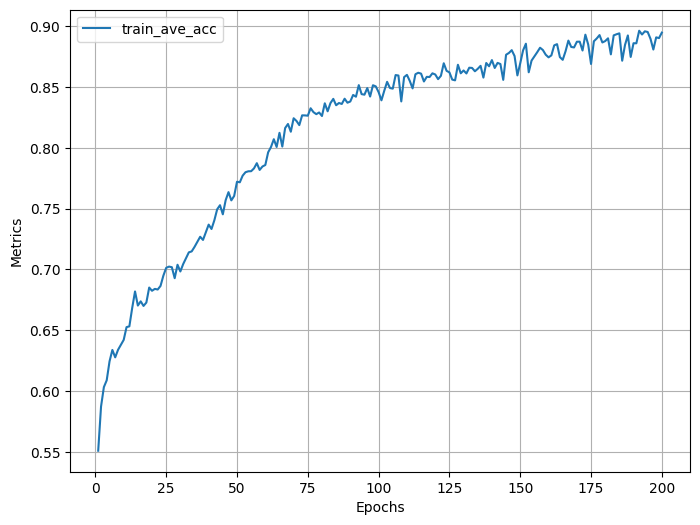

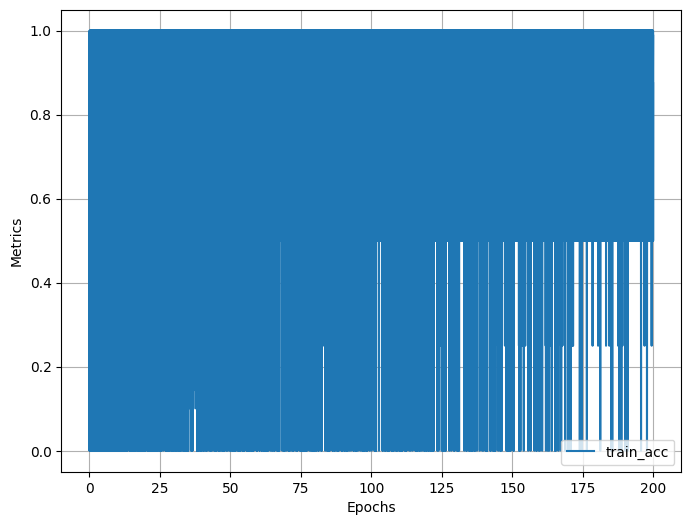

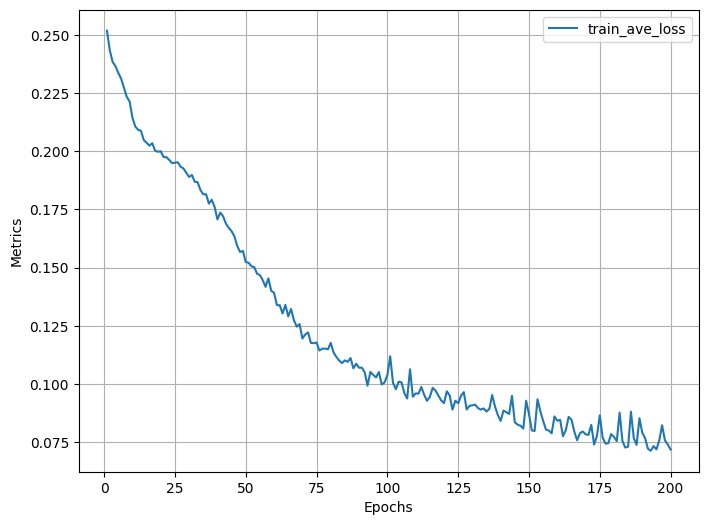

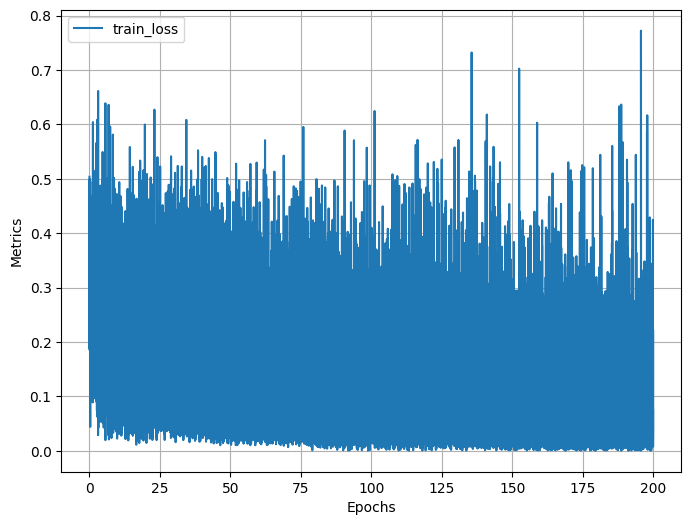

In [4]:
nn_mc_report.plot('train_ave_acc')
nn_mc_report.plot('train_acc')
nn_mc_report.plot('train_ave_loss')
nn_mc_report.plot('train_loss')

#### Evaluation

In [5]:
from data import test_dataset
import evaluation as eval
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nn_mc_model.eval()
def nn_mc_predict(sa_pair):
    single_sample_reshape = sa_pair.reshape(1,-1)
    pred = nn_mc_model(torch.from_numpy(single_sample_reshape).float().to(device))
    return pred

nn_mc_score, nn_mc_mse = eval.score_model(test_dataset, nn_mc_predict)

def nn_mc_predict_seq(sa_pair_seq):
    pred = nn_mc_model(torch.from_numpy(sa_pair_seq).float().to(device))
    return pred

nn_mc_seq_score, nn_mc_seq_mse = eval.score_model_sequential(test_dataset, nn_mc_predict_seq)

print(f"NN MC Accuracy: {nn_mc_score}")
print(f"NN MC MSE: {nn_mc_mse}")
print(f"NN MC Seq Accuracy: {nn_mc_seq_score}")
print(f"NN MC Seq MSE: {nn_mc_seq_mse}")

NN MC Accuracy: 0.5536159600997507
NN MC MSE: 0.34532413036316273
NN MC Seq Accuracy: 0.5922693266832918
NN MC Seq MSE: 0.3276030444646966


### SARSA

#### Training (Without MC Init)

In [6]:
import d_sarsa

nn_sarsa_model, nn_sarsa_report = d_sarsa.train(save=False, use_mc=False)

EPOCH: 1.000  train_ave_loss: 0.157  train_ave_acc: 0.499  (2.60s - 516.77s remaining) ave_loss: 0.15658533615756595 ave_acc: 0.4992028589745307
EPOCH: 2.000  train_ave_loss: 0.135  train_ave_acc: 0.515  (5.48s - 542.17s remaining) ave_loss: 0.13510591233056313 ave_acc: 0.5154617062808914
EPOCH: 3.000  train_ave_loss: 0.133  train_ave_acc: 0.532  (8.50s - 558.25s remaining) ave_loss: 0.13310717978675868 ave_acc: 0.5317421709402476
EPOCH: 4.000  train_ave_loss: 0.128  train_ave_acc: 0.531  (11.27s - 552.42s remaining) ave_loss: 0.12760346680005624 ave_acc: 0.5314874449186893
EPOCH: 5.000  train_ave_loss: 0.125  train_ave_acc: 0.544  (14.22s - 554.57s remaining) ave_loss: 0.1253659405098283 ave_acc: 0.5444225989535837
EPOCH: 6.000  train_ave_loss: 0.125  train_ave_acc: 0.538  (17.18s - 555.58s remaining) ave_loss: 0.12527893652697025 ave_acc: 0.5384059203654871
EPOCH: 7.000  train_ave_loss: 0.101  train_ave_acc: 0.594  (20.12s - 554.76s remaining) ave_loss: 0.1012781643830349 ave_acc: 0.

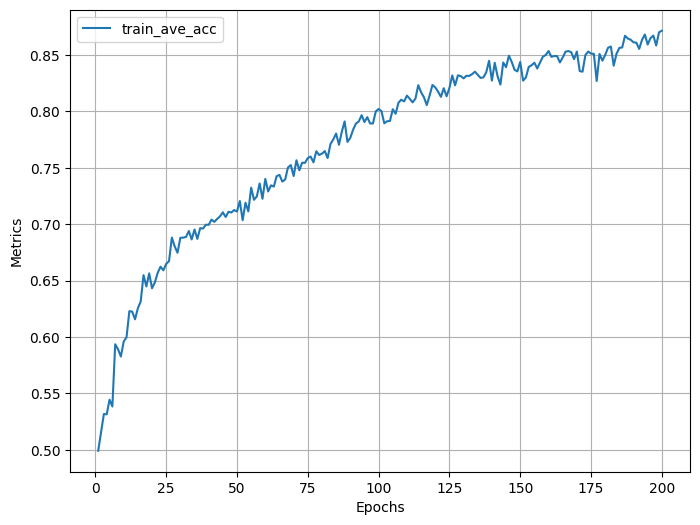

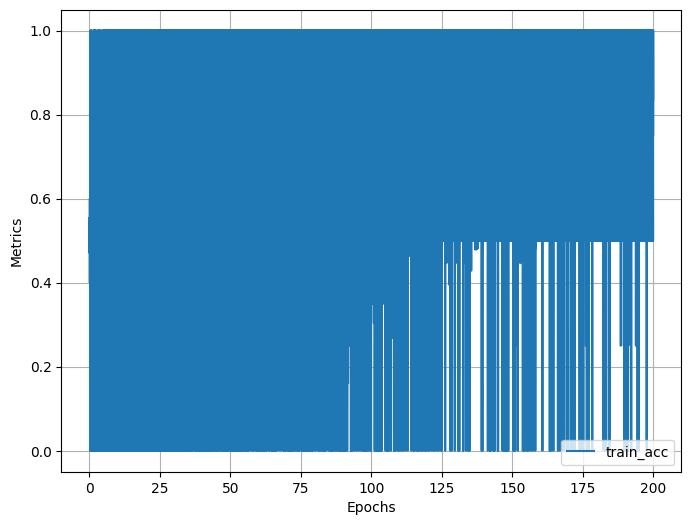

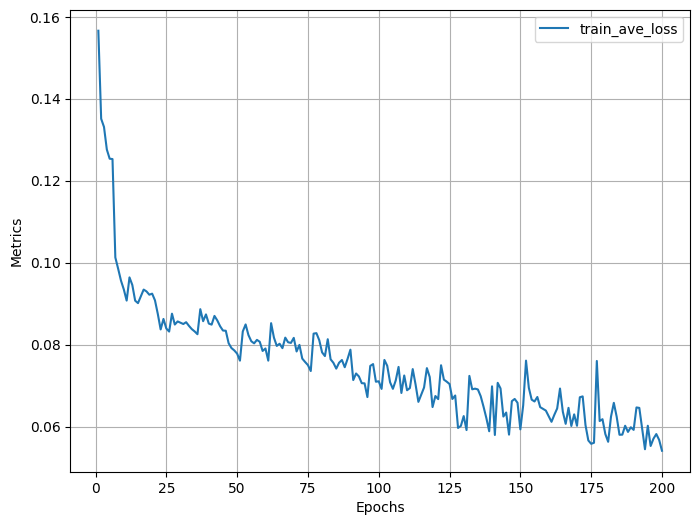

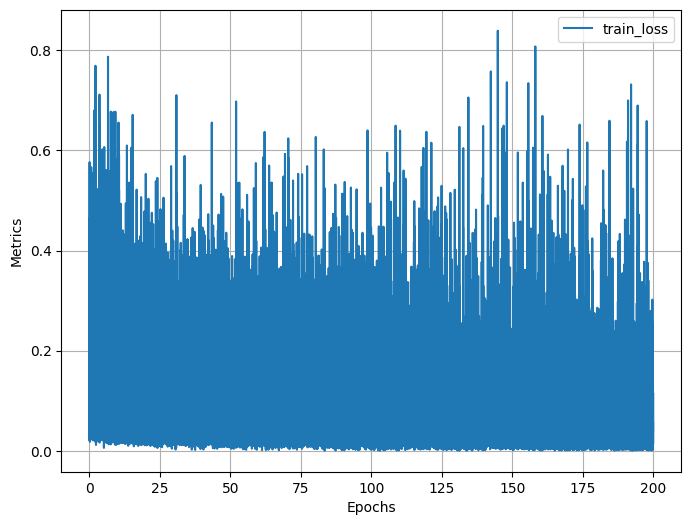

In [7]:
nn_sarsa_report.plot('train_ave_acc')
nn_sarsa_report.plot('train_acc')
nn_sarsa_report.plot('train_ave_loss')
nn_sarsa_report.plot('train_loss')

#### Evaluation (Without MC Init)

In [8]:
from data import test_dataset
import evaluation as eval
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nn_sarsa_model.eval()
def nn_predict(sa_pair):
    single_sample_reshape = sa_pair.reshape(1,-1)
    pred = nn_sarsa_model(torch.from_numpy(single_sample_reshape).float().to(device))
    return pred

nn_sarsa_score, nn_sarsa_mse = eval.score_model(test_dataset, nn_predict)

def nn_predict_seq(sa_pair_seq):
    pred = nn_sarsa_model(torch.from_numpy(sa_pair_seq).float().to(device))
    return pred

nn_sarsa_seq_score, nn_sarsa_seq_mse = eval.score_model_sequential(test_dataset, nn_predict_seq)

print(f"NN Sarsa Accuracy: {nn_sarsa_score}")
print(f"NN Sarsa MSE: {nn_sarsa_mse}")
print(f"NN Sarsa Seq Accuracy: {nn_sarsa_seq_score}")
print(f"NN Sarsa Seq MSE: {nn_sarsa_seq_mse}")

NN Sarsa Accuracy: 0.5660847880299252
NN Sarsa MSE: 0.29595363501113064
NN Sarsa Seq Accuracy: 0.6172069825436409
NN Sarsa Seq MSE: 0.26517271792149205


#### Training (With MC Init)

In [9]:
import d_sarsa

nn_mc_state_dict = nn_mc_model.state_dict()
nn_sarsa_with_mc_model, nn_sarsa_with_mc_report = d_sarsa.train(save=False, use_mc=False, init_state_dict=nn_mc_state_dict)

Init state dictionary was passed. Using that to initialize model_net.
EPOCH: 1.000  train_ave_loss: 0.075  train_ave_acc: 0.884  (2.73s - 542.49s remaining) ave_loss: 0.07511067596097583 ave_acc: 0.8839358841786265
EPOCH: 2.000  train_ave_loss: 0.071  train_ave_acc: 0.872  (5.45s - 539.57s remaining) ave_loss: 0.07078619803714394 ave_acc: 0.8716603034148865
EPOCH: 3.000  train_ave_loss: 0.065  train_ave_acc: 0.872  (8.18s - 537.40s remaining) ave_loss: 0.06512848837942956 ave_acc: 0.8718606625556686
EPOCH: 4.000  train_ave_loss: 0.062  train_ave_acc: 0.869  (10.92s - 535.00s remaining) ave_loss: 0.06163526885860116 ave_acc: 0.869119835916478
EPOCH: 5.000  train_ave_loss: 0.065  train_ave_acc: 0.857  (13.62s - 531.04s remaining) ave_loss: 0.06465994016591001 ave_acc: 0.8567467286479058
EPOCH: 6.000  train_ave_loss: 0.061  train_ave_acc: 0.859  (16.33s - 527.86s remaining) ave_loss: 0.061302466775137725 ave_acc: 0.8590649455135402
EPOCH: 7.000  train_ave_loss: 0.069  train_ave_acc: 0.862

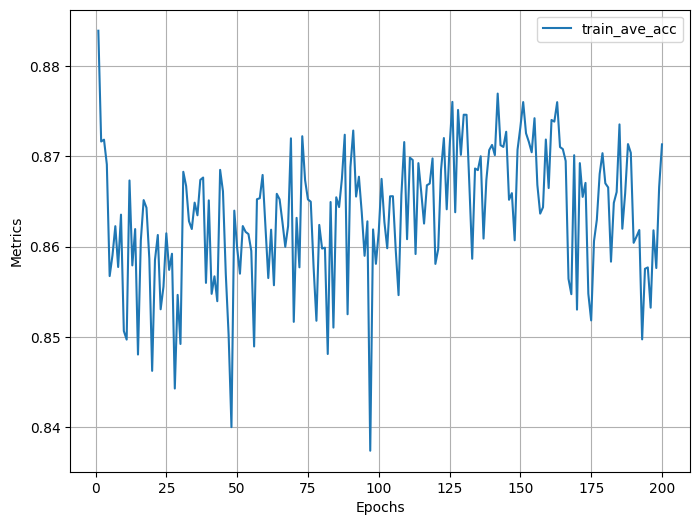

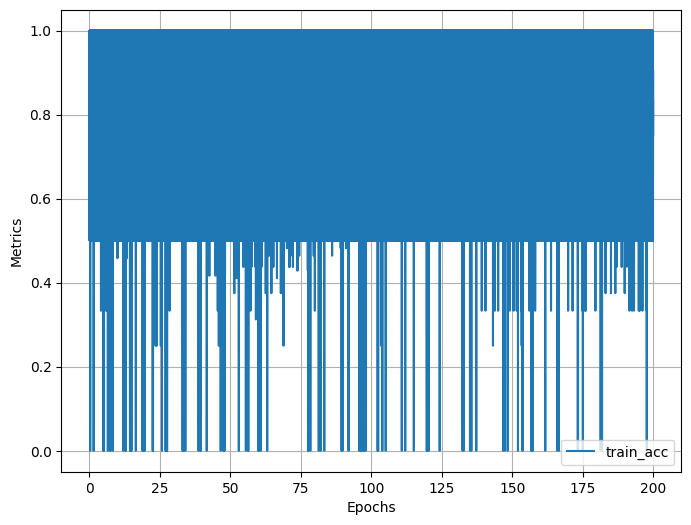

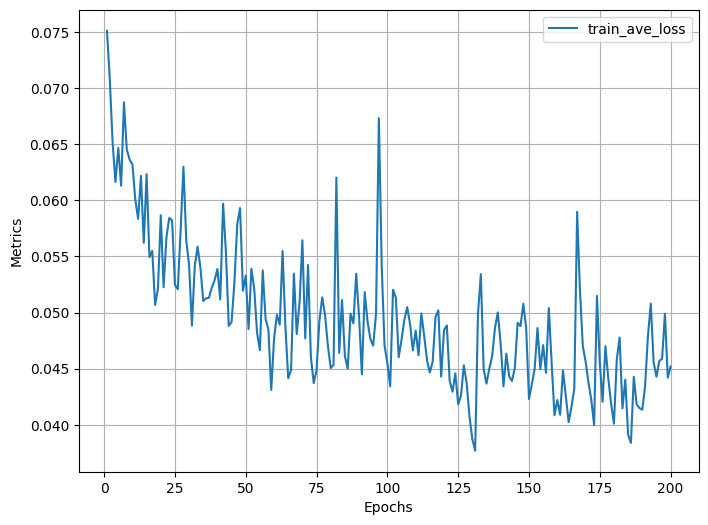

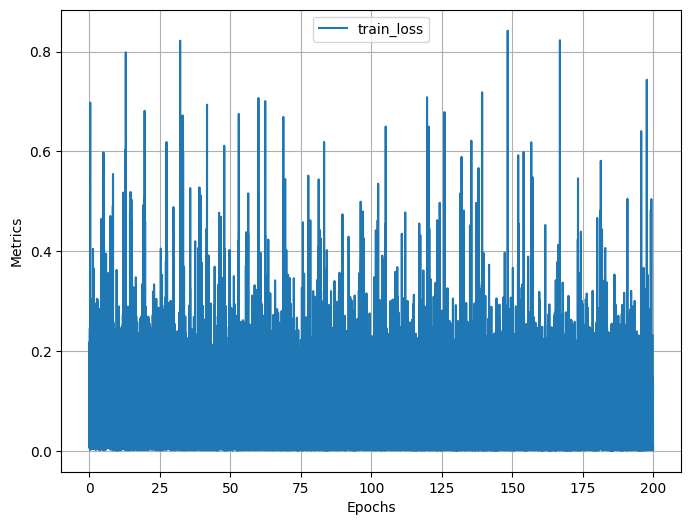

In [10]:
nn_sarsa_with_mc_report.plot('train_ave_acc')
nn_sarsa_with_mc_report.plot('train_acc')
nn_sarsa_with_mc_report.plot('train_ave_loss')
nn_sarsa_with_mc_report.plot('train_loss')

#### Evaluation (With MC Init)

In [11]:
from data import test_dataset
import evaluation as eval
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

nn_sarsa_with_mc_model.eval()
def nn_sarsa_with_mc_predict(sa_pair):
    single_sample_reshape = sa_pair.reshape(1,-1)
    pred = nn_sarsa_with_mc_model(torch.from_numpy(single_sample_reshape).float().to(device))
    return pred

nn_sarsa_with_mc_score, nn_sarsa_with_mc_mse = eval.score_model(test_dataset, nn_sarsa_with_mc_predict)

def nn_sarsa_with_mc_predict_seq(sa_pair_seq):
    pred = nn_sarsa_with_mc_model(torch.from_numpy(sa_pair_seq).float().to(device))
    return pred

nn_sarsa_with_mc_seq_score, nn_sarsa_with_mc_seq_mse = eval.score_model_sequential(test_dataset, nn_sarsa_with_mc_predict_seq)

print(f"NN Sarsa With MC Init Accuracy: {nn_sarsa_with_mc_score}")
print(f"NN Sarsa With MC Init MSE: {nn_sarsa_with_mc_mse}")
print(f"NN Sarsa With MC Init Seq Accuracy: {nn_sarsa_with_mc_seq_score}")
print(f"NN Sarsa With MC Init Seq MSE: {nn_sarsa_with_mc_seq_mse}")

NN Sarsa With MC Init Accuracy: 0.5660847880299252
NN Sarsa With MC Init MSE: 0.31159913795701
NN Sarsa With MC Init Seq Accuracy: 0.6483790523690773
NN Sarsa With MC Init Seq MSE: 0.2651342781791387


In [12]:
import os

model_dirpath = 'experiment_models/200epoch_5e-4lr_vanilla_paper_params'
os.makedirs(model_dirpath, exist_ok=True)


torch.save(nn_mc_model.state_dict(), os.path.join(model_dirpath, 'nn_mc_model.pth'))
torch.save(nn_sarsa_model.state_dict(), os.path.join(model_dirpath, 'nn_sarsa_model.pth'))
torch.save(nn_sarsa_with_mc_model.state_dict(), os.path.join(model_dirpath, 'nn_sarsa_with_mc_model.pth'))

## Conclusion

### Summary

### Future extensions